In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import lsqr
from scipy.optimize import least_squares
import datetime as dt
from scipy.integrate import trapezoid, simpson
from scipy.optimize import curve_fit
from scipy import signal

In [2]:
# Option to work with either fake data or true data
load_fake_data = True

In [3]:
if (load_fake_data == True):
    rootdir = 'scizone1_nooffset/'
    init_points = 0
    err_idx = []

else:
    rootdir = '20220114_20220115_data/20220114_2326_2333/'
    # For avoiding FGM initialization issues from interfering with calibration
    init_points = 30
    # For fixing timestamp issues with FGM clock
    err_idx = [1020, 1045]

In [4]:
# Load in IGRF field and attitude in GEI
igrf_dat_dir = rootdir + 'elx_bt89_gei.txt'
att_dat_dir = rootdir + 'elx_att_gei.txt'

# Load in raw sensor data
fgmc_dat_dir = rootdir + 'elx_fgs.txt'

# Load in IGRF field in DMXL, just to see if we can find anything reasonable-looking like FACs
# This won't be used in calibration though
dmxl_dat_dir = rootdir + 'elx_bt89_dmxl.txt'

In [5]:
igrf_data = np.loadtxt(igrf_dat_dir, dtype=str)
att_data = np.loadtxt(att_dat_dir, dtype=str)
fgmc_data = np.loadtxt(fgmc_dat_dir, dtype=str)
dmxl_data = np.loadtxt(dmxl_dat_dir, dtype=str)

In [6]:
# Unpack relative timestamps
times = list(fgmc_data[:,0])
times = [t.replace('/', ' ') for t in times]
data = pd.DataFrame(times, columns = ['Time (Full)'])
data['Time (Full)'] = pd.to_datetime(data['Time (Full)'])
data['Time (Full)'] = data['Time (Full)']-data['Time (Full)'][0]
data['ctime'] = data['Time (Full)'].dt.total_seconds()
data = data.drop('Time (Full)', axis=1)
ctime = np.array(data['ctime'])

In [7]:
# Fix timing issues
if(len(err_idx)!=0):

    mid_idx = [i for i in range(err_idx[0]+1, err_idx[1])]
    shift_idx = [i for i in range(err_idx[0], err_idx[1]+1)]
    shift = np.median(np.abs((ctime[1:]-ctime[:-1])[err_idx] - np.median(ctime[mid_idx][1:]-ctime[mid_idx][:-1])))
    shift_idx_act = [i for i in range(err_idx[0]+1, err_idx[1]+1)]
    ctime[shift_idx_act] -= shift

In [8]:
# Unpack 3-D vectors
ctime = ctime[init_points:]-np.min(ctime[init_points:])

B_IGRF_GEI_x = np.float_(igrf_data[:,1])[init_points:]
B_IGRF_GEI_y = np.float_(igrf_data[:,2])[init_points:]
B_IGRF_GEI_z = np.float_(igrf_data[:,3])[init_points:]

att_GEI_x = np.float_(att_data[:, 1])[init_points:]
att_GEI_y = np.float_(att_data[:, 2])[init_points:]
att_GEI_z = np.float_(att_data[:, 3])[init_points:]

B_raw_FGM_x = np.float_(fgmc_data[:,1])[init_points:]
B_raw_FGM_y = np.float_(fgmc_data[:,2])[init_points:]
B_raw_FGM_z = np.float_(fgmc_data[:,3])[init_points:]

B_IGRF_DMXL_x_load = np.float_(dmxl_data[:,1])[init_points:]
B_IGRF_DMXL_y_load = np.float_(dmxl_data[:,2])[init_points:]
B_IGRF_DMXL_z_load = np.float_(dmxl_data[:,3])[init_points:]

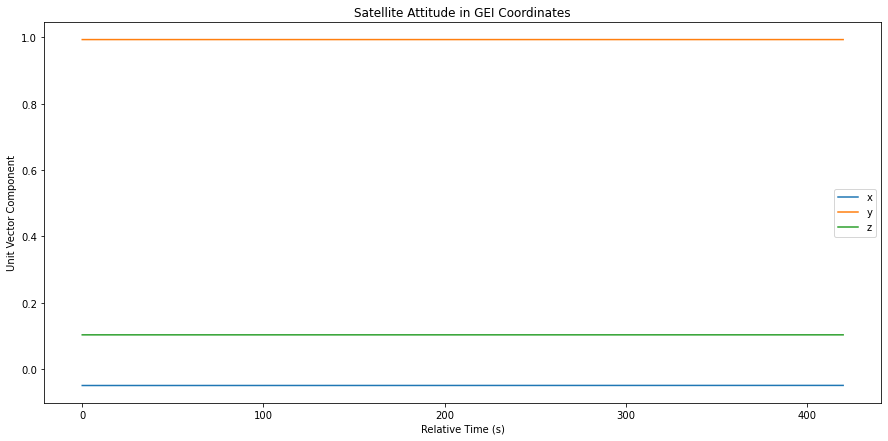

In [9]:
fig, ax = plt.subplots(1, figsize = (15, 7))

ax.plot(ctime, att_GEI_x, label='x')
ax.plot(ctime, att_GEI_y, label='y')
ax.plot(ctime, att_GEI_z, label='z')

ax.set_title('Satellite Attitude in GEI Coordinates')
ax.set_xlabel('Relative Time (s)')
ax.set_ylabel('Unit Vector Component')
ax.legend()

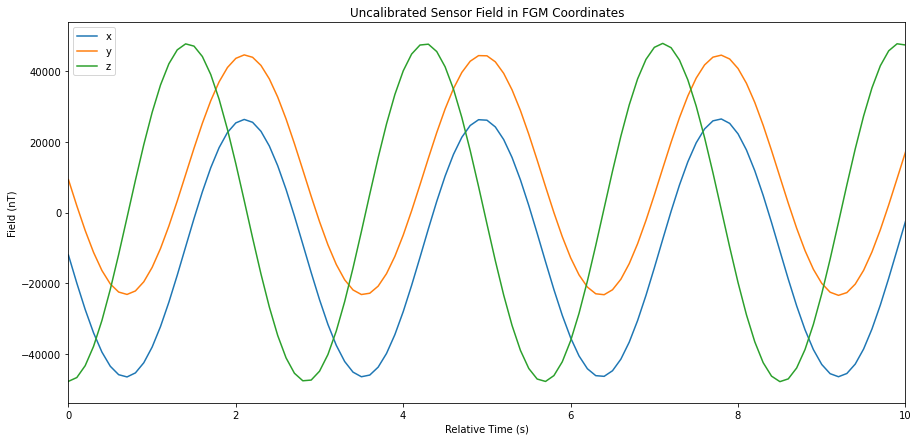

In [10]:
fig, ax = plt.subplots(1, figsize = (15, 7))

ax.plot(ctime, B_raw_FGM_x, label='x')
ax.plot(ctime, B_raw_FGM_y, label='y')
ax.plot(ctime, B_raw_FGM_z, label='z')

ax.set_title('Uncalibrated Sensor Field in FGM Coordinates')
ax.set_xlabel('Relative Time (s)')
ax.set_ylabel('Field (nT)')
ax.set_xlim(0, 10)
ax.legend()

In [11]:
# IGRF field directions in GEI
B_hat_IGRF_GEI_x = B_IGRF_GEI_x/np.sqrt(B_IGRF_GEI_x**2 + B_IGRF_GEI_y**2 + B_IGRF_GEI_z**2)
B_hat_IGRF_GEI_y = B_IGRF_GEI_y/np.sqrt(B_IGRF_GEI_x**2 + B_IGRF_GEI_y**2 + B_IGRF_GEI_z**2)
B_hat_IGRF_GEI_z = B_IGRF_GEI_z/np.sqrt(B_IGRF_GEI_x**2 + B_IGRF_GEI_y**2 + B_IGRF_GEI_z**2)

Just as a sanity check, let us try constructing DMXL coordinates from scratch and see if they match the IDL definition

In [12]:
DMXL_2_GEI = np.zeros((len(ctime), 3, 3))

In [13]:
for i in range(len(ctime)):
    
    u_hat = np.array([att_GEI_x[i], att_GEI_y[i], att_GEI_z[i]])
    b_hat = np.array([B_hat_IGRF_GEI_x[i], B_hat_IGRF_GEI_y[i], B_hat_IGRF_GEI_z[i]])
    
    DMXL_2_GEI[i,:,0] = np.cross(b_hat, u_hat)
    DMXL_2_GEI[i,:,1] = np.cross(u_hat, np.cross(b_hat, u_hat))
    DMXL_2_GEI[i,:,2] = u_hat
    
    DMXL_2_GEI[i,:,0] /= np.linalg.norm(DMXL_2_GEI[i,:,0])
    DMXL_2_GEI[i,:,1] /= np.linalg.norm(DMXL_2_GEI[i,:,1])
    DMXL_2_GEI[i,:,2] /= np.linalg.norm(DMXL_2_GEI[i,:,2]) 

In [14]:
B_IGRF_DMXL_x = np.zeros(len(ctime))
B_IGRF_DMXL_y = np.zeros(len(ctime))
B_IGRF_DMXL_z = np.zeros(len(ctime))

for i in range(len(ctime)):
    
    GEI_2_DMXL = np.linalg.inv(DMXL_2_GEI[i])
    
    B_IGRF_DMXL_x[i] = GEI_2_DMXL[0,0]*B_IGRF_GEI_x[i] + GEI_2_DMXL[0,1]*B_IGRF_GEI_y[i] + GEI_2_DMXL[0,2]*B_IGRF_GEI_z[i]
    B_IGRF_DMXL_y[i] = GEI_2_DMXL[1,0]*B_IGRF_GEI_x[i] + GEI_2_DMXL[1,1]*B_IGRF_GEI_y[i] + GEI_2_DMXL[1,2]*B_IGRF_GEI_z[i]
    B_IGRF_DMXL_z[i] = GEI_2_DMXL[2,0]*B_IGRF_GEI_x[i] + GEI_2_DMXL[2,1]*B_IGRF_GEI_y[i] + GEI_2_DMXL[2,2]*B_IGRF_GEI_z[i]    

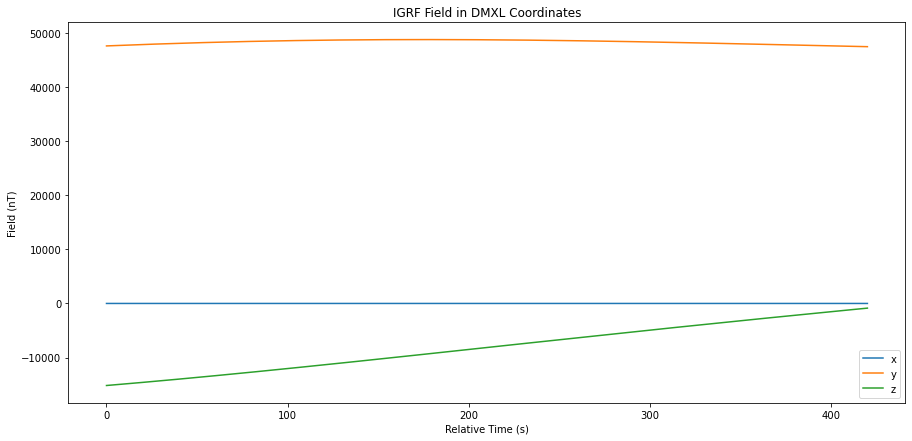

In [15]:
fig, ax = plt.subplots(1, figsize = (15, 7))

ax.plot(ctime, B_IGRF_DMXL_x, label='x')
ax.plot(ctime, B_IGRF_DMXL_y, label='y')
ax.plot(ctime, B_IGRF_DMXL_z, label='z')

ax.set_title('IGRF Field in DMXL Coordinates')
ax.set_xlabel('Relative Time (s)')
ax.set_ylabel('Field (nT)')
ax.legend()

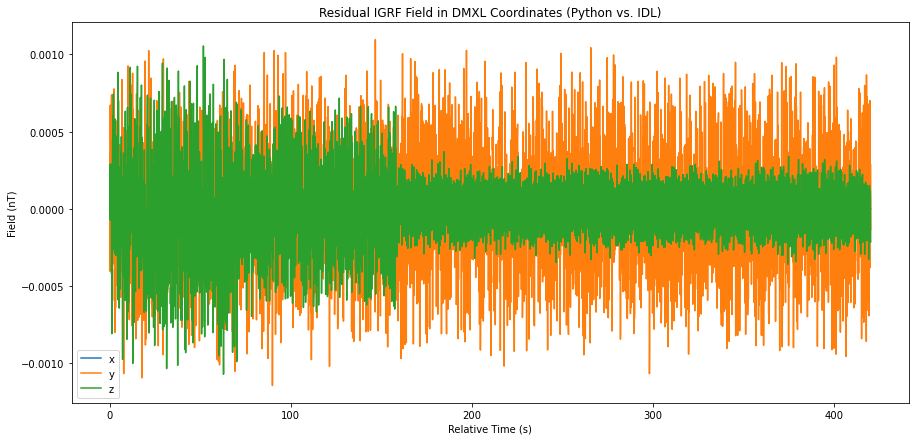

In [16]:
fig, ax = plt.subplots(1, figsize = (15, 7))

ax.plot(ctime, B_IGRF_DMXL_x-B_IGRF_DMXL_x_load, label='x')
ax.plot(ctime, B_IGRF_DMXL_y-B_IGRF_DMXL_y_load, label='y')
ax.plot(ctime, B_IGRF_DMXL_z-B_IGRF_DMXL_z_load, label='z')

ax.set_title('Residual IGRF Field in DMXL Coordinates (Python vs. IDL)')
ax.set_xlabel('Relative Time (s)')
ax.set_ylabel('Field (nT)')
ax.legend()

Close enough, so if we don't detect FACs later, we'll know it's not because of any discrepancies in the coordinate frame definition

In [17]:
# Spherical representation of unit vector
# Same implementation as in 3-const_w_calibrate.ipynb

def calc_unit_vec_angles(v_hat):
    
    v_hat_x = v_hat[0]
    v_hat_y = v_hat[1]
    v_hat_z = v_hat[2]
    
    theta = np.arccos(v_hat_z)
    
    cos_phi = v_hat_x/np.sin(theta)
    sin_phi = v_hat_y/np.sin(theta)

    if(cos_phi>0 and sin_phi>0):
        phi = np.arcsin(sin_phi)

    elif(cos_phi<0 and sin_phi>0):
        phi = np.arccos(cos_phi)

    elif(cos_phi<0 and sin_phi<0):
        phi = 2*np.pi-np.arccos(cos_phi)

    else:
        phi = 2*np.pi+np.arcsin(sin_phi)
        
    return np.array([theta, phi])

In [18]:
# Creating the transformation from DSC to GEI
# Same implementation as in 3-const_w_calibrate.ipynb

def orth_mat_create(att_angles, b_hat):
    
    orth_mat = np.zeros((3, 3))
    
    u_hat = np.array([np.sin(att_angles[0])*np.cos(att_angles[1]), 
          np.sin(att_angles[0])*np.sin(att_angles[1]), 
          np.cos(att_angles[0])])
     
    orth_mat[:,0] = np.cross(b_hat, u_hat)
    orth_mat[:,1] = np.cross(u_hat, np.cross(b_hat, u_hat))
    orth_mat[:,2] = u_hat
    
    orth_mat[:,0] /= np.linalg.norm(orth_mat[:,0])
    orth_mat[:,1] /= np.linalg.norm(orth_mat[:,1])
    orth_mat[:,2] /= np.linalg.norm(orth_mat[:,2])    
    
    return orth_mat

In [19]:
# For calculating gradients, relevant to attitude correction
# Same implementation as in 3-const_w_calibrate.ipynb

def diff_orth_mat(att_angles, b_hat, i, eps = 1e-8):
    
    orth_mat_init = np.linalg.inv(orth_mat_create(att_angles, b_hat))
            
    att_angles_final = att_angles.copy()

    att_angles_final[i] += eps
            
    orth_mat_final = np.linalg.inv(orth_mat_create(att_angles_final, b_hat))

    orth_mat_diff = (orth_mat_final-orth_mat_init)/eps
    
    return orth_mat_diff

In [20]:
b_hat = np.array([B_hat_IGRF_GEI_x[0], B_hat_IGRF_GEI_y[0], B_hat_IGRF_GEI_z[0]])

# Initial guesses for attitude

u_hat_init = np.array([np.mean(att_GEI_x), np.mean(att_GEI_y), np.mean(att_GEI_z)])
u_hat_true = u_hat_init.copy()

att_angles_init = calc_unit_vec_angles(u_hat_init)
att_angles_true = att_angles_init.copy()

# Corrupt true values in case of simulated data

if(load_fake_data == True):
    
    att_angles_init[0] += 1e-5
    att_angles_init[1] += 1e-6
    
    u_hat_init = np.array([np.sin(att_angles_init[0])*np.cos(att_angles_init[1]), 
          np.sin(att_angles_init[0])*np.sin(att_angles_init[1]), 
          np.cos(att_angles_init[0])])

# We simply use zero-values for actual ELFIN data, 
# This helps us track the converged values in addition to checking for convergence itself

else:
    u_hat_true = np.zeros(3)
    att_angles_true = np.zeros(2)

In [21]:
# Again, initial guesses and true values based on simulated or actual ELFIN data

if(load_fake_data == True):
    
    T_true = 2.84
    T_eps = 1e-5
    T_init = T_true + T_eps
    
    w_true = 2*np.pi/T_true
    w_init = 2*np.pi/T_init
    
else:
    # We again use zeros for true values in case of actual ELFIN data
    T_true = 0
    T_init = 2.83

    w_true = 0
    w_init = 2*np.pi/T_init

In [22]:
# Zero-crossing analysis for phi0

d_B_raw_FGM_z = np.gradient(B_raw_FGM_z)/np.gradient(ctime)

for j in range(len(ctime)-1):
    if(d_B_raw_FGM_z[j]*d_B_raw_FGM_z[j+1]<0 and d_B_raw_FGM_z[j]>0):
        y1 = d_B_raw_FGM_z[j]
        y2 = d_B_raw_FGM_z[j+1]
        x1 = ctime[j]
        x2 = ctime[j+1]
        t0_init = (y2*x1 - y1*x2)/(y2 - y1)
        break

phase_init = np.zeros(len(ctime))

idx = ((ctime-t0_init)>=-T_init/2) & ((ctime-t0_init)<=T_init/2)
phase_init[idx] = np.arcsin(d_B_raw_FGM_z[idx]/np.max(np.abs(d_B_raw_FGM_z[idx])))

for k in range(len(ctime)-1):
    if(phase_init[k]*phase_init[k+1]<0 and phase_init[k]>0):
        y1 = phase_init[k]
        y2 = phase_init[k+1]
        x1 = ctime[k]
        x2 = ctime[k+1]
        t0_init = (y2*x1 - y1*x2)/(y2 - y1)
        break

In [23]:
phi0_init = (-w_init*t0_init)%(2*np.pi)

if (load_fake_data == True):
    phi0_true = np.pi
else:
    phi0_true = 0

In [24]:
f = 44*np.pi/180
FGM_2_RSC = np.array([[np.cos(f),np.sin(f),0],[0,0,1],[np.sin(f),-np.cos(f),0]])
RSC_2_FGM = np.linalg.inv(FGM_2_RSC)

In [25]:
n_iter = 1000

In [26]:
# Arrays for storing the progress of guesses for various observables
u_hat_arr = np.zeros((n_iter+1, 3))
att_angles_arr = np.zeros((n_iter+1, 2))
T_arr = np.zeros(n_iter+1)
w_arr = np.zeros(n_iter+1)
phi0_arr = np.zeros(n_iter+1)
orth_arr = np.zeros((n_iter+1, 3, 3))
offsets_arr = np.zeros((n_iter+1, 3))

In [27]:
if(load_fake_data == True):
    orth_true = np.array([[1.01, 0.05, 0.04], [0.02, 1.0, 0.03], [0.006, 0.006, 1.0]])
    offsets_true = np.array([3, -4, -5])
    
else:
    orth_true = np.zeros((3, 3))
    offsets_true = np.zeros(3)

In [28]:
# Initializing progress arrays as appropriate
u_hat_arr[0] = u_hat_init
att_angles_arr[0] = att_angles_init
T_arr[0] = T_init
w_arr[0] = w_init
phi0_arr[0] = phi0_init
orth_arr[0] = np.eye(3)
offsets_arr[0] = np.zeros(3)

In [29]:
for i in range(n_iter):
    
    ##########################################################################
    ## Generate IGRF field in FGM coordinates and calibrate raw sensor data ##
    ##########################################################################
    
    DSC_2_GEI_init = orth_mat_create(att_angles_init, b_hat)
    
    GEI_2_DSC_init = np.linalg.inv(DSC_2_GEI_init)

    B_IGRF_DSC_x = GEI_2_DSC_init[0,0]*B_IGRF_GEI_x + GEI_2_DSC_init[0,1]*B_IGRF_GEI_y + GEI_2_DSC_init[0,2]*B_IGRF_GEI_z
    B_IGRF_DSC_y = GEI_2_DSC_init[1,0]*B_IGRF_GEI_x + GEI_2_DSC_init[1,1]*B_IGRF_GEI_y + GEI_2_DSC_init[1,2]*B_IGRF_GEI_z
    B_IGRF_DSC_z = GEI_2_DSC_init[2,0]*B_IGRF_GEI_x + GEI_2_DSC_init[2,1]*B_IGRF_GEI_y + GEI_2_DSC_init[2,2]*B_IGRF_GEI_z

    phi_init = w_init*ctime + phi0_init
    
    B_IGRF_RSC_x = np.cos(phi_init)*B_IGRF_DSC_x + np.sin(phi_init)*B_IGRF_DSC_y
    B_IGRF_RSC_y = -np.sin(phi_init)*B_IGRF_DSC_x + np.cos(phi_init)*B_IGRF_DSC_y
    B_IGRF_RSC_z = B_IGRF_DSC_z
    
    B_IGRF_FGM_x = RSC_2_FGM[0,0]*B_IGRF_RSC_x + RSC_2_FGM[0,1]*B_IGRF_RSC_y + RSC_2_FGM[0,2]*B_IGRF_RSC_z
    B_IGRF_FGM_y = RSC_2_FGM[1,0]*B_IGRF_RSC_x + RSC_2_FGM[1,1]*B_IGRF_RSC_y + RSC_2_FGM[1,2]*B_IGRF_RSC_z
    B_IGRF_FGM_z = RSC_2_FGM[2,0]*B_IGRF_RSC_x + RSC_2_FGM[2,1]*B_IGRF_RSC_y + RSC_2_FGM[2,2]*B_IGRF_RSC_z
    
    n = len(ctime)
    
    b_FGM_cal = np.concatenate((B_raw_FGM_x, B_raw_FGM_y, B_raw_FGM_z))

    A_FGM_cal = np.zeros((3*n, 12))

    A_FGM_cal[0:n,0] = B_IGRF_FGM_x
    A_FGM_cal[0:n,1] = B_IGRF_FGM_y
    A_FGM_cal[0:n,2] = B_IGRF_FGM_z
    A_FGM_cal[0:n,3] = np.ones(n)
    A_FGM_cal[n:2*n,4] = B_IGRF_FGM_x
    A_FGM_cal[n:2*n,5] = B_IGRF_FGM_y
    A_FGM_cal[n:2*n,6] = B_IGRF_FGM_z
    A_FGM_cal[n:2*n,7] = np.ones(n)
    A_FGM_cal[2*n:3*n,8] = B_IGRF_FGM_x
    A_FGM_cal[2*n:3*n,9] = B_IGRF_FGM_y
    A_FGM_cal[2*n:3*n,10] = B_IGRF_FGM_z
    A_FGM_cal[2*n:3*n,11] = np.ones(n)

    A_FGM_cal = csc_matrix(A_FGM_cal)
    
    x_FGM_cal = lsqr(A_FGM_cal, b_FGM_cal, atol=1e-10, btol=1e-10)[0]    
    
    orth = np.array([[x_FGM_cal[0],x_FGM_cal[1],x_FGM_cal[2]], 
                     [x_FGM_cal[4], x_FGM_cal[5], x_FGM_cal[6]], 
                     [x_FGM_cal[8], x_FGM_cal[9], x_FGM_cal[10]]])

    offsets = np.array([x_FGM_cal[3], x_FGM_cal[7], x_FGM_cal[11]])
    
    calib = np.linalg.inv(orth)
    
    ##########################################################################
    ## Transform calibrated sensor data to RSC coordinates and correct phi0 ##
    ##########################################################################
    
    B_cal_FGM_x = calib[0, 0]*(B_raw_FGM_x-offsets[0]) + calib[0, 1]*(B_raw_FGM_y-offsets[1]) + calib[0, 2]*(B_raw_FGM_z-offsets[2])
    B_cal_FGM_y = calib[1, 0]*(B_raw_FGM_x-offsets[0]) + calib[1, 1]*(B_raw_FGM_y-offsets[1]) + calib[1, 2]*(B_raw_FGM_z-offsets[2])
    B_cal_FGM_z = calib[2, 0]*(B_raw_FGM_x-offsets[0]) + calib[2, 1]*(B_raw_FGM_y-offsets[1]) + calib[2, 2]*(B_raw_FGM_z-offsets[2]) 

    B_cal_RSC_x = FGM_2_RSC[0,0]*B_cal_FGM_x + FGM_2_RSC[0,1]*B_cal_FGM_y + FGM_2_RSC[0,2]*B_cal_FGM_z
    B_cal_RSC_y = FGM_2_RSC[1,0]*B_cal_FGM_x + FGM_2_RSC[1,1]*B_cal_FGM_y + FGM_2_RSC[1,2]*B_cal_FGM_z
    B_cal_RSC_z = FGM_2_RSC[2,0]*B_cal_FGM_x + FGM_2_RSC[2,1]*B_cal_FGM_y + FGM_2_RSC[2,2]*B_cal_FGM_z

    b_phi0_cal = np.concatenate((B_cal_RSC_x, B_cal_RSC_y))

    A_phi0_cal = np.zeros((2*n, 2))

    A_phi0_cal[0:n,0] = np.cos(w_init*ctime)*B_IGRF_DSC_x + np.sin(w_init*ctime)*B_IGRF_DSC_y
    A_phi0_cal[0:n,1] = np.cos(w_init*ctime)*B_IGRF_DSC_y - np.sin(w_init*ctime)*B_IGRF_DSC_x
    A_phi0_cal[n:2*n,0] = np.cos(w_init*ctime)*B_IGRF_DSC_y - np.sin(w_init*ctime)*B_IGRF_DSC_x
    A_phi0_cal[n:2*n,1] = -np.cos(w_init*ctime)*B_IGRF_DSC_x + np.sin(w_init*ctime)*B_IGRF_DSC_y

    A_phi0_cal = csc_matrix(A_phi0_cal)
    
    x_phi0_cal = lsqr(A_phi0_cal, b_phi0_cal, atol=1e-10, btol=1e-10)[0]
    
    cos_phi0_final = x_phi0_cal[0]/np.sqrt(x_phi0_cal[0]**2 + x_phi0_cal[1]**2)
    sin_phi0_final = x_phi0_cal[1]/np.sqrt(x_phi0_cal[0]**2 + x_phi0_cal[1]**2)
            
    if(cos_phi0_final>0 and sin_phi0_final>0):
        phi0_final = np.arcsin(sin_phi0_final)

    elif(cos_phi0_final<0 and sin_phi0_final>0):
        phi0_final = np.arccos(cos_phi0_final)

    elif(cos_phi0_final<0 and sin_phi0_final<0):
        phi0_final = 2*np.pi-np.arccos(cos_phi0_final)

    else:
        phi0_final = 2*np.pi+np.arcsin(sin_phi0_final)
        
    phi_re = w_init*ctime + phi0_final
    
    ################################################################################
    ## Re-generate IGRF field in FGM coordinates and re-calibrate raw sensor data ##
    ################################################################################
    
    B_IGRF_RSC_x_re = np.cos(phi_re)*B_IGRF_DSC_x + np.sin(phi_re)*B_IGRF_DSC_y
    B_IGRF_RSC_y_re = -np.sin(phi_re)*B_IGRF_DSC_x + np.cos(phi_re)*B_IGRF_DSC_y
    B_IGRF_RSC_z_re = B_IGRF_DSC_z
    
    B_IGRF_FGM_x_re = RSC_2_FGM[0,0]*B_IGRF_RSC_x_re + RSC_2_FGM[0,1]*B_IGRF_RSC_y_re + RSC_2_FGM[0,2]*B_IGRF_RSC_z_re
    B_IGRF_FGM_y_re = RSC_2_FGM[1,0]*B_IGRF_RSC_x_re + RSC_2_FGM[1,1]*B_IGRF_RSC_y_re + RSC_2_FGM[1,2]*B_IGRF_RSC_z_re
    B_IGRF_FGM_z_re = RSC_2_FGM[2,0]*B_IGRF_RSC_x_re + RSC_2_FGM[2,1]*B_IGRF_RSC_y_re + RSC_2_FGM[2,2]*B_IGRF_RSC_z_re
    
    A_FGM_cal = np.zeros((3*n, 12))

    A_FGM_cal[0:n,0] = B_IGRF_FGM_x_re
    A_FGM_cal[0:n,1] = B_IGRF_FGM_y_re
    A_FGM_cal[0:n,2] = B_IGRF_FGM_z_re
    A_FGM_cal[0:n,3] = np.ones(n)
    A_FGM_cal[n:2*n,4] = B_IGRF_FGM_x_re
    A_FGM_cal[n:2*n,5] = B_IGRF_FGM_y_re
    A_FGM_cal[n:2*n,6] = B_IGRF_FGM_z_re
    A_FGM_cal[n:2*n,7] = np.ones(n)
    A_FGM_cal[2*n:3*n,8] = B_IGRF_FGM_x_re
    A_FGM_cal[2*n:3*n,9] = B_IGRF_FGM_y_re
    A_FGM_cal[2*n:3*n,10] = B_IGRF_FGM_z_re
    A_FGM_cal[2*n:3*n,11] = np.ones(n)

    A_FGM_cal = csc_matrix(A_FGM_cal)
    
    x_FGM_cal = lsqr(A_FGM_cal, b_FGM_cal, atol=1e-10, btol=1e-10)[0]    
    
    orth = np.array([[x_FGM_cal[0],x_FGM_cal[1],x_FGM_cal[2]], 
                     [x_FGM_cal[4], x_FGM_cal[5], x_FGM_cal[6]], 
                     [x_FGM_cal[8], x_FGM_cal[9], x_FGM_cal[10]]])

    offsets = np.array([x_FGM_cal[3], x_FGM_cal[7], x_FGM_cal[11]])
    
    calib = np.linalg.inv(orth)
    
    #######################################################################
    ## Transform calibrated sensor data to RSC coordinates and correct w ##
    #######################################################################
    
    B_cal_FGM_x = calib[0, 0]*(B_raw_FGM_x-offsets[0]) + calib[0, 1]*(B_raw_FGM_y-offsets[1]) + calib[0, 2]*(B_raw_FGM_z-offsets[2])
    B_cal_FGM_y = calib[1, 0]*(B_raw_FGM_x-offsets[0]) + calib[1, 1]*(B_raw_FGM_y-offsets[1]) + calib[1, 2]*(B_raw_FGM_z-offsets[2])
    B_cal_FGM_z = calib[2, 0]*(B_raw_FGM_x-offsets[0]) + calib[2, 1]*(B_raw_FGM_y-offsets[1]) + calib[2, 2]*(B_raw_FGM_z-offsets[2]) 

    B_cal_RSC_x = FGM_2_RSC[0,0]*B_cal_FGM_x + FGM_2_RSC[0,1]*B_cal_FGM_y + FGM_2_RSC[0,2]*B_cal_FGM_z
    B_cal_RSC_y = FGM_2_RSC[1,0]*B_cal_FGM_x + FGM_2_RSC[1,1]*B_cal_FGM_y + FGM_2_RSC[1,2]*B_cal_FGM_z
    B_cal_RSC_z = FGM_2_RSC[2,0]*B_cal_FGM_x + FGM_2_RSC[2,1]*B_cal_FGM_y + FGM_2_RSC[2,2]*B_cal_FGM_z
    
    Y_x = B_cal_RSC_x-B_IGRF_RSC_x_re
    Y_y = B_cal_RSC_y-B_IGRF_RSC_y_re
    Y_z = B_cal_RSC_z-B_IGRF_RSC_z_re

    Y = np.concatenate((Y_x, Y_y, Y_z))
    
    X_x = ctime*(-np.sin(phi_re)*B_IGRF_DSC_x + np.cos(phi_re)*B_IGRF_DSC_y)
    X_y = ctime*(-np.cos(phi_re)*B_IGRF_DSC_x - np.sin(phi_re)*B_IGRF_DSC_y)
    X_z = ctime*0

    X = np.concatenate((X_x, X_y, X_z))
    
    delta_w = np.sum(X*Y)/np.sum(X**2)
    
    w_final = w_init + delta_w
    
    phi_final = w_final*ctime + phi0_final
    
    ################################################################################
    ## Re-generate IGRF field in FGM coordinates and re-calibrate raw sensor data ##
    ################################################################################
    
    B_IGRF_RSC_x_final = np.cos(phi_final)*B_IGRF_DSC_x + np.sin(phi_final)*B_IGRF_DSC_y
    B_IGRF_RSC_y_final = -np.sin(phi_final)*B_IGRF_DSC_x + np.cos(phi_final)*B_IGRF_DSC_y
    B_IGRF_RSC_z_final = B_IGRF_DSC_z
    
    B_IGRF_FGM_x_final = RSC_2_FGM[0,0]*B_IGRF_RSC_x_final + RSC_2_FGM[0,1]*B_IGRF_RSC_y_final + RSC_2_FGM[0,2]*B_IGRF_RSC_z_final
    B_IGRF_FGM_y_final = RSC_2_FGM[1,0]*B_IGRF_RSC_x_final + RSC_2_FGM[1,1]*B_IGRF_RSC_y_final + RSC_2_FGM[1,2]*B_IGRF_RSC_z_final
    B_IGRF_FGM_z_final = RSC_2_FGM[2,0]*B_IGRF_RSC_x_final + RSC_2_FGM[2,1]*B_IGRF_RSC_y_final + RSC_2_FGM[2,2]*B_IGRF_RSC_z_final
    
    A_FGM_cal = np.zeros((3*n, 12))

    A_FGM_cal[0:n,0] = B_IGRF_FGM_x_final
    A_FGM_cal[0:n,1] = B_IGRF_FGM_y_final
    A_FGM_cal[0:n,2] = B_IGRF_FGM_z_final
    A_FGM_cal[0:n,3] = np.ones(n)
    A_FGM_cal[n:2*n,4] = B_IGRF_FGM_x_final
    A_FGM_cal[n:2*n,5] = B_IGRF_FGM_y_final
    A_FGM_cal[n:2*n,6] = B_IGRF_FGM_z_final
    A_FGM_cal[n:2*n,7] = np.ones(n)
    A_FGM_cal[2*n:3*n,8] = B_IGRF_FGM_x_final
    A_FGM_cal[2*n:3*n,9] = B_IGRF_FGM_y_final
    A_FGM_cal[2*n:3*n,10] = B_IGRF_FGM_z_final
    A_FGM_cal[2*n:3*n,11] = np.ones(n)

    A_FGM_cal = csc_matrix(A_FGM_cal)
    
    x_FGM_cal = lsqr(A_FGM_cal, b_FGM_cal, atol=1e-10, btol=1e-10)[0]    
    
    orth = np.array([[x_FGM_cal[0],x_FGM_cal[1],x_FGM_cal[2]], 
                     [x_FGM_cal[4], x_FGM_cal[5], x_FGM_cal[6]], 
                     [x_FGM_cal[8], x_FGM_cal[9], x_FGM_cal[10]]])

    offsets = np.array([x_FGM_cal[3], x_FGM_cal[7], x_FGM_cal[11]])
    
    calib = np.linalg.inv(orth)
    
    ##############################################################################
    ## Transform calibrated sensor data to DSC coordinates and correct attitude ##
    ##############################################################################
    
    B_cal_FGM_x = calib[0, 0]*(B_raw_FGM_x-offsets[0]) + calib[0, 1]*(B_raw_FGM_y-offsets[1]) + calib[0, 2]*(B_raw_FGM_z-offsets[2])
    B_cal_FGM_y = calib[1, 0]*(B_raw_FGM_x-offsets[0]) + calib[1, 1]*(B_raw_FGM_y-offsets[1]) + calib[1, 2]*(B_raw_FGM_z-offsets[2])
    B_cal_FGM_z = calib[2, 0]*(B_raw_FGM_x-offsets[0]) + calib[2, 1]*(B_raw_FGM_y-offsets[1]) + calib[2, 2]*(B_raw_FGM_z-offsets[2]) 

    B_cal_RSC_x = FGM_2_RSC[0,0]*B_cal_FGM_x + FGM_2_RSC[0,1]*B_cal_FGM_y + FGM_2_RSC[0,2]*B_cal_FGM_z
    B_cal_RSC_y = FGM_2_RSC[1,0]*B_cal_FGM_x + FGM_2_RSC[1,1]*B_cal_FGM_y + FGM_2_RSC[1,2]*B_cal_FGM_z
    B_cal_RSC_z = FGM_2_RSC[2,0]*B_cal_FGM_x + FGM_2_RSC[2,1]*B_cal_FGM_y + FGM_2_RSC[2,2]*B_cal_FGM_z
    
    B_cal_DSC_x = np.cos(phi_final)*B_cal_RSC_x - np.sin(phi_final)*B_cal_RSC_y
    B_cal_DSC_y = np.sin(phi_final)*B_cal_RSC_x + np.cos(phi_final)*B_cal_RSC_y
    B_cal_DSC_z = B_cal_RSC_z
    
    b_u_hat_cal = np.zeros(3*n)

    b_u_hat_cal[0:n] = B_cal_DSC_x - B_IGRF_DSC_x
    b_u_hat_cal[n:2*n] = B_cal_DSC_y - B_IGRF_DSC_y
    b_u_hat_cal[2*n:3*n] = B_cal_DSC_z - B_IGRF_DSC_z  

    d_theta_u_GEI_2_DSC_init = diff_orth_mat(att_angles_init, b_hat, 0)
    d_phi_u_GEI_2_DSC_init = diff_orth_mat(att_angles_init, b_hat, 1)

    A_u_hat_cal = np.zeros((3*n, 2))

    A_u_hat_cal[0:n,0] = d_theta_u_GEI_2_DSC_init[0,0]*B_IGRF_GEI_x + d_theta_u_GEI_2_DSC_init[0,1]*B_IGRF_GEI_y + d_theta_u_GEI_2_DSC_init[0,2]*B_IGRF_GEI_z
    A_u_hat_cal[0:n,1] = d_phi_u_GEI_2_DSC_init[0,0]*B_IGRF_GEI_x + d_phi_u_GEI_2_DSC_init[0,1]*B_IGRF_GEI_y + d_phi_u_GEI_2_DSC_init[0,2]*B_IGRF_GEI_z

    A_u_hat_cal[n:2*n,0] = d_theta_u_GEI_2_DSC_init[1,0]*B_IGRF_GEI_x + d_theta_u_GEI_2_DSC_init[1,1]*B_IGRF_GEI_y + d_theta_u_GEI_2_DSC_init[1,2]*B_IGRF_GEI_z
    A_u_hat_cal[n:2*n,1] = d_phi_u_GEI_2_DSC_init[1,0]*B_IGRF_GEI_x + d_phi_u_GEI_2_DSC_init[1,1]*B_IGRF_GEI_y + d_phi_u_GEI_2_DSC_init[1,2]*B_IGRF_GEI_z

    A_u_hat_cal[2*n:3*n,0] = d_theta_u_GEI_2_DSC_init[2,0]*B_IGRF_GEI_x + d_theta_u_GEI_2_DSC_init[2,1]*B_IGRF_GEI_y + d_theta_u_GEI_2_DSC_init[2,2]*B_IGRF_GEI_z
    A_u_hat_cal[2*n:3*n,1] = d_phi_u_GEI_2_DSC_init[2,0]*B_IGRF_GEI_x + d_phi_u_GEI_2_DSC_init[2,1]*B_IGRF_GEI_y + d_phi_u_GEI_2_DSC_init[2,2]*B_IGRF_GEI_z

    A_u_hat_cal = csc_matrix(A_u_hat_cal)

    x_u_hat_cal = lsqr(A_u_hat_cal, b_u_hat_cal, atol=1e-10, btol=1e-10)[0] 
    
    att_angles_del = np.array([x_u_hat_cal[0], x_u_hat_cal[1]])
    
    att_angles_final = att_angles_init + att_angles_del
    
    u_hat_final = np.array([np.sin(att_angles_final[0])*np.cos(att_angles_final[1]), 
                              np.sin(att_angles_final[0])*np.sin(att_angles_final[1]), 
                              np.cos(att_angles_final[0])])
    
    DSC_2_GEI_final = orth_mat_create(att_angles_final, b_hat)
    
    GEI_2_DSC_final = np.linalg.inv(DSC_2_GEI_final)
    
    ################################################################################
    ## Re-generate IGRF field in FGM coordinates and re-calibrate raw sensor data ##
    ################################################################################
    
    B_IGRF_DSC_x_final = GEI_2_DSC_final[0,0]*B_IGRF_GEI_x + GEI_2_DSC_final[0,1]*B_IGRF_GEI_y + GEI_2_DSC_final[0,2]*B_IGRF_GEI_z
    B_IGRF_DSC_y_final = GEI_2_DSC_final[1,0]*B_IGRF_GEI_x + GEI_2_DSC_final[1,1]*B_IGRF_GEI_y + GEI_2_DSC_final[1,2]*B_IGRF_GEI_z
    B_IGRF_DSC_z_final = GEI_2_DSC_final[2,0]*B_IGRF_GEI_x + GEI_2_DSC_final[2,1]*B_IGRF_GEI_y + GEI_2_DSC_final[2,2]*B_IGRF_GEI_z
    
    B_IGRF_RSC_x_final = np.cos(phi_final)*B_IGRF_DSC_x_final + np.sin(phi_final)*B_IGRF_DSC_y_final
    B_IGRF_RSC_y_final = -np.sin(phi_final)*B_IGRF_DSC_x_final + np.cos(phi_final)*B_IGRF_DSC_y_final
    B_IGRF_RSC_z_final = B_IGRF_DSC_z_final
    
    B_IGRF_FGM_x_final = RSC_2_FGM[0,0]*B_IGRF_RSC_x_final + RSC_2_FGM[0,1]*B_IGRF_RSC_y_final + RSC_2_FGM[0,2]*B_IGRF_RSC_z_final
    B_IGRF_FGM_y_final = RSC_2_FGM[1,0]*B_IGRF_RSC_x_final + RSC_2_FGM[1,1]*B_IGRF_RSC_y_final + RSC_2_FGM[1,2]*B_IGRF_RSC_z_final
    B_IGRF_FGM_z_final = RSC_2_FGM[2,0]*B_IGRF_RSC_x_final + RSC_2_FGM[2,1]*B_IGRF_RSC_y_final + RSC_2_FGM[2,2]*B_IGRF_RSC_z_final
    
    A_FGM_cal = np.zeros((3*n, 12))

    A_FGM_cal[0:n,0] = B_IGRF_FGM_x_final
    A_FGM_cal[0:n,1] = B_IGRF_FGM_y_final
    A_FGM_cal[0:n,2] = B_IGRF_FGM_z_final
    A_FGM_cal[0:n,3] = np.ones(n)
    A_FGM_cal[n:2*n,4] = B_IGRF_FGM_x_final
    A_FGM_cal[n:2*n,5] = B_IGRF_FGM_y_final
    A_FGM_cal[n:2*n,6] = B_IGRF_FGM_z_final
    A_FGM_cal[n:2*n,7] = np.ones(n)
    A_FGM_cal[2*n:3*n,8] = B_IGRF_FGM_x_final
    A_FGM_cal[2*n:3*n,9] = B_IGRF_FGM_y_final
    A_FGM_cal[2*n:3*n,10] = B_IGRF_FGM_z_final
    A_FGM_cal[2*n:3*n,11] = np.ones(n)

    A_FGM_cal = csc_matrix(A_FGM_cal)
    
    x_FGM_cal = lsqr(A_FGM_cal, b_FGM_cal, atol=1e-10, btol=1e-10)[0]
    
    orth = np.array([[x_FGM_cal[0],x_FGM_cal[1],x_FGM_cal[2]], 
                     [x_FGM_cal[4], x_FGM_cal[5], x_FGM_cal[6]], 
                     [x_FGM_cal[8], x_FGM_cal[9], x_FGM_cal[10]]])

    offsets = np.array([x_FGM_cal[3], x_FGM_cal[7], x_FGM_cal[11]])
    
    calib = np.linalg.inv(orth)
    
    #####################################################################
    ## Apply calibrations to raw sensor field, despin the sensor field ##
    #####################################################################
    
    B_cal_FGM_x = calib[0, 0]*(B_raw_FGM_x-offsets[0]) + calib[0, 1]*(B_raw_FGM_y-offsets[1]) + calib[0, 2]*(B_raw_FGM_z-offsets[2])
    B_cal_FGM_y = calib[1, 0]*(B_raw_FGM_x-offsets[0]) + calib[1, 1]*(B_raw_FGM_y-offsets[1]) + calib[1, 2]*(B_raw_FGM_z-offsets[2])
    B_cal_FGM_z = calib[2, 0]*(B_raw_FGM_x-offsets[0]) + calib[2, 1]*(B_raw_FGM_y-offsets[1]) + calib[2, 2]*(B_raw_FGM_z-offsets[2]) 
    
    B_cal_RSC_x = FGM_2_RSC[0,0]*B_cal_FGM_x + FGM_2_RSC[0,1]*B_cal_FGM_y + FGM_2_RSC[0,2]*B_cal_FGM_z
    B_cal_RSC_y = FGM_2_RSC[1,0]*B_cal_FGM_x + FGM_2_RSC[1,1]*B_cal_FGM_y + FGM_2_RSC[1,2]*B_cal_FGM_z
    B_cal_RSC_z = FGM_2_RSC[2,0]*B_cal_FGM_x + FGM_2_RSC[2,1]*B_cal_FGM_y + FGM_2_RSC[2,2]*B_cal_FGM_z
    
    B_cal_DSC_x = np.cos(phi_final)*B_cal_RSC_x - np.sin(phi_final)*B_cal_RSC_y
    B_cal_DSC_y = np.sin(phi_final)*B_cal_RSC_x + np.cos(phi_final)*B_cal_RSC_y
    B_cal_DSC_z = B_cal_RSC_z
    
    B_cal_GEI_x = DSC_2_GEI_final[0,0]*B_cal_DSC_x + DSC_2_GEI_final[0,1]*B_cal_DSC_y + DSC_2_GEI_final[0,2]*B_cal_DSC_z
    B_cal_GEI_y = DSC_2_GEI_final[1,0]*B_cal_DSC_x + DSC_2_GEI_final[1,1]*B_cal_DSC_y + DSC_2_GEI_final[1,2]*B_cal_DSC_z
    B_cal_GEI_z = DSC_2_GEI_final[2,0]*B_cal_DSC_x + DSC_2_GEI_final[2,1]*B_cal_DSC_y + DSC_2_GEI_final[2,2]*B_cal_DSC_z
    
    ############################################################################
    ## Store progress of variables being optimized to check convergence later ##
    ############################################################################
    
    u_hat_init = u_hat_final
    att_angles_init = att_angles_final
    
    T_init = 2*np.pi/w_final
    w_init = w_final
    
    phi0_init = phi0_final
    
    u_hat_arr[i+1] = u_hat_init
    att_angles_arr[i+1] = att_angles_init
    T_arr[i+1] = T_init
    w_arr[i+1] = w_init
    phi0_arr[i+1] = phi0_init
    orth_arr[i+1] = orth
    offsets_arr[i+1] = offsets

In case of simulated data, the converged values of the optimization variables is extremely close to the true values!

In [30]:
u_hat_init-u_hat_true

array([-4.34409005e-05, -6.74429846e-06,  4.41481430e-05])

In [31]:
T_init-T_true

5.997630037057888e-08

In [32]:
phi0_init-phi0_true

6.989264100809578e-08

In [33]:
orth-orth_true

array([[ 5.54417104e-05, -5.35439653e-05, -1.00406898e-07],
       [-5.50068235e-05,  6.05569110e-05, -1.20348714e-07],
       [ 2.20356189e-07,  2.73508430e-07,  3.50832935e-06]])

In [34]:
offsets-offsets_true

array([ 1.46836697e+00, -1.55738810e+00, -5.62772476e-04])

The plots below can be used to track convergence of various quantities over iterations. For simulated data, we plot the difference of the estimates for variables from their true values, while for actual ELFIN data, we plot just the estimates themselves.

Text(0, 0.5, 'Spin Period (rad/s)')

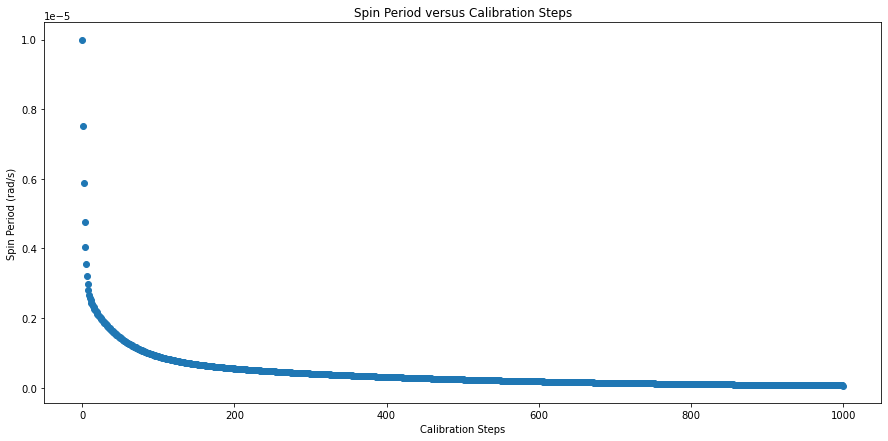

In [35]:
fig, ax = plt.subplots(1, figsize = (15, 7))

ax.scatter(np.arange(n_iter+1), T_arr-T_true)
ax.set_title('Spin Period versus Calibration Steps')
ax.set_xlabel('Calibration Steps')
ax.set_ylabel('Spin Period (rad/s)')

Text(0, 0.5, 'Angular Velocity (rad/s)')

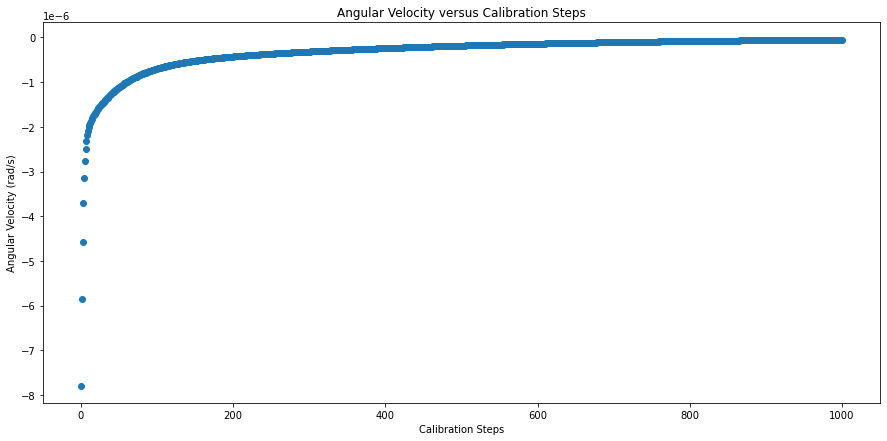

In [36]:
fig, ax = plt.subplots(1, figsize = (15, 7))

ax.scatter(np.arange(n_iter+1), w_arr-w_true)
ax.set_title('Angular Velocity versus Calibration Steps')
ax.set_xlabel('Calibration Steps')
ax.set_ylabel('Angular Velocity (rad/s)')

Text(0, 0.5, 'Angular Velocity (rad/s)')

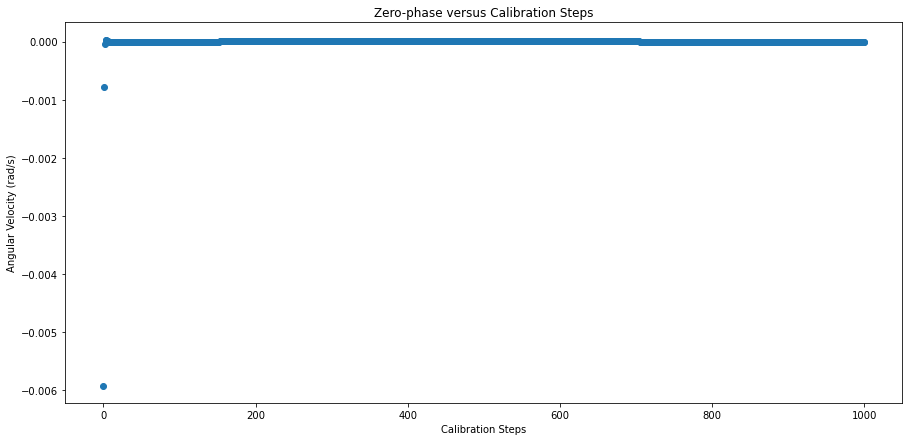

In [37]:
fig, ax = plt.subplots(1, figsize = (15, 7))

ax.scatter(np.arange(n_iter+1), phi0_arr-phi0_true)
ax.set_title('Zero-phase versus Calibration Steps')
ax.set_xlabel('Calibration Steps')
ax.set_ylabel('Angular Velocity (rad/s)')

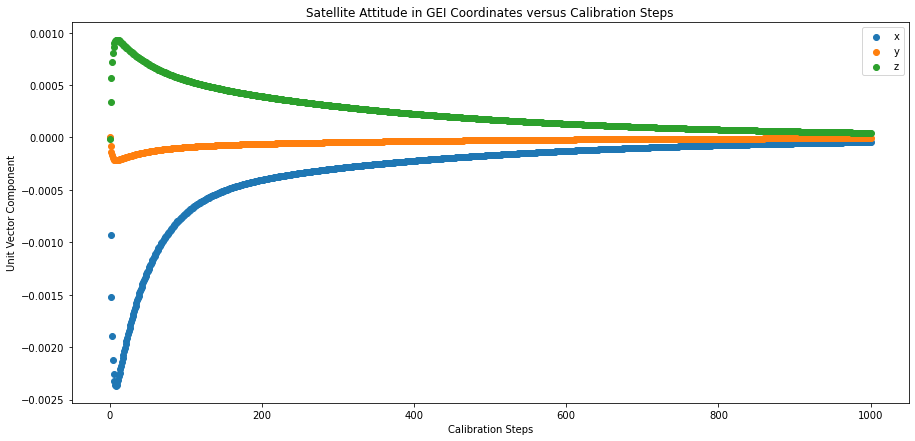

In [38]:
fig, ax = plt.subplots(1, figsize = (15, 7))

ax.scatter(np.arange(n_iter+1), u_hat_arr[:,0]-u_hat_true[0], label='x')
ax.scatter(np.arange(n_iter+1), u_hat_arr[:,1]-u_hat_true[1], label='y')
ax.scatter(np.arange(n_iter+1), u_hat_arr[:,2]-u_hat_true[2], label='z')

ax.set_title('Satellite Attitude in GEI Coordinates versus Calibration Steps')
ax.set_xlabel('Calibration Steps')
ax.set_ylabel('Unit Vector Component')
ax.legend()

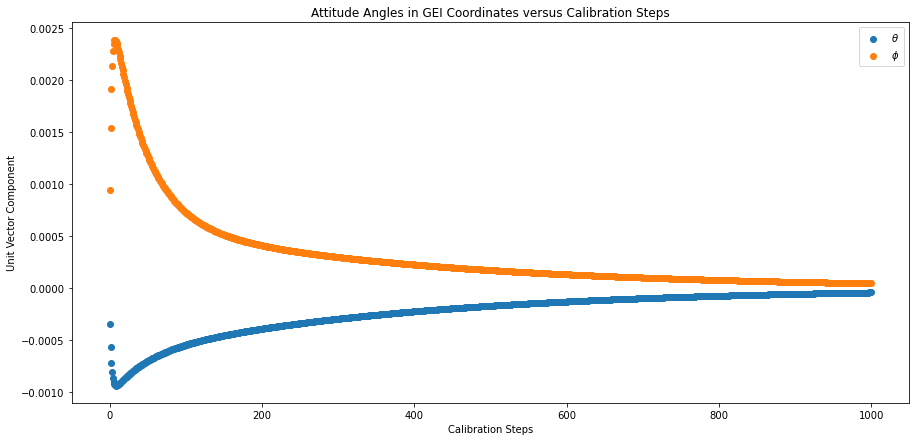

In [39]:
fig, ax = plt.subplots(1, figsize = (15, 7))

ax.scatter(np.arange(n_iter), att_angles_arr[1:,0]-att_angles_true[0], label=r'$\theta$')
ax.scatter(np.arange(n_iter), att_angles_arr[1:,1]-att_angles_true[1], label=r'$\phi$')

ax.set_title('Attitude Angles in GEI Coordinates versus Calibration Steps')
ax.set_xlabel('Calibration Steps')
ax.set_ylabel('Unit Vector Component')
ax.legend()

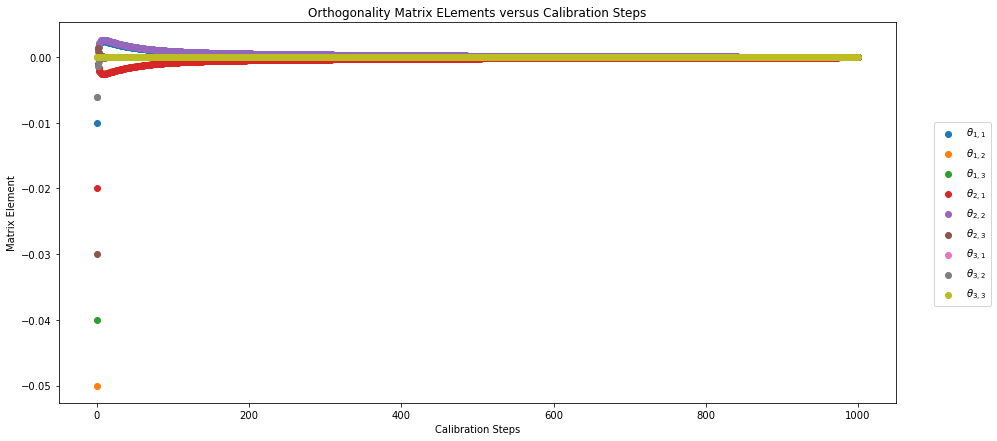

In [40]:
fig, ax = plt.subplots(1, figsize = (15, 7))

ax.scatter(np.arange(n_iter+1), orth_arr[:,0,0]-orth_true[0,0], label=r'$\theta_{1,1}$')
ax.scatter(np.arange(n_iter+1), orth_arr[:,0,1]-orth_true[0,1], label=r'$\theta_{1,2}$')
ax.scatter(np.arange(n_iter+1), orth_arr[:,0,2]-orth_true[0,2], label=r'$\theta_{1,3}$')
ax.scatter(np.arange(n_iter+1), orth_arr[:,1,0]-orth_true[1,0], label=r'$\theta_{2,1}$')
ax.scatter(np.arange(n_iter+1), orth_arr[:,1,1]-orth_true[1,1], label=r'$\theta_{2,2}$')
ax.scatter(np.arange(n_iter+1), orth_arr[:,1,2]-orth_true[1,2], label=r'$\theta_{2,3}$')
ax.scatter(np.arange(n_iter+1), orth_arr[:,2,0]-orth_true[2,0], label=r'$\theta_{3,1}$')
ax.scatter(np.arange(n_iter+1), orth_arr[:,2,1]-orth_true[2,1], label=r'$\theta_{3,2}$')
ax.scatter(np.arange(n_iter+1), orth_arr[:,2,2]-orth_true[2,2], label=r'$\theta_{3,3}$')

ax.set_title('Orthogonality Matrix ELements versus Calibration Steps')
ax.set_xlabel('Calibration Steps')
ax.set_ylabel('Matrix Element')

ax.legend(bbox_to_anchor=(1.04,.75), loc="upper left")

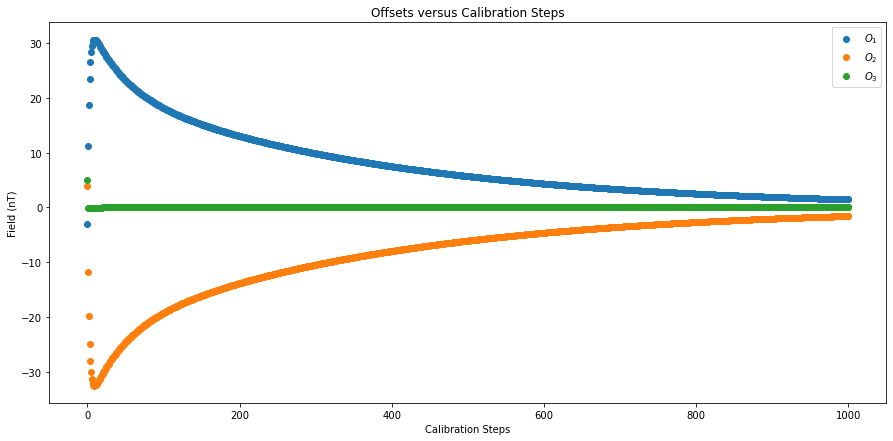

In [41]:
fig, ax = plt.subplots(1, figsize = (15, 7))

ax.scatter(np.arange(n_iter+1), offsets_arr[:,0]-offsets_true[0], label=r'$O_{1}$')
ax.scatter(np.arange(n_iter+1), offsets_arr[:,1]-offsets_true[1], label=r'$O_{2}$')
ax.scatter(np.arange(n_iter+1), offsets_arr[:,2]-offsets_true[2], label=r'$O_{3}$')

ax.set_title('Offsets versus Calibration Steps')
ax.set_xlabel('Calibration Steps')
ax.set_ylabel('Field (nT)')
ax.legend()

Next, we look at the residuals of the calibrated field from IGRF in GEI and DMXL coordinates.

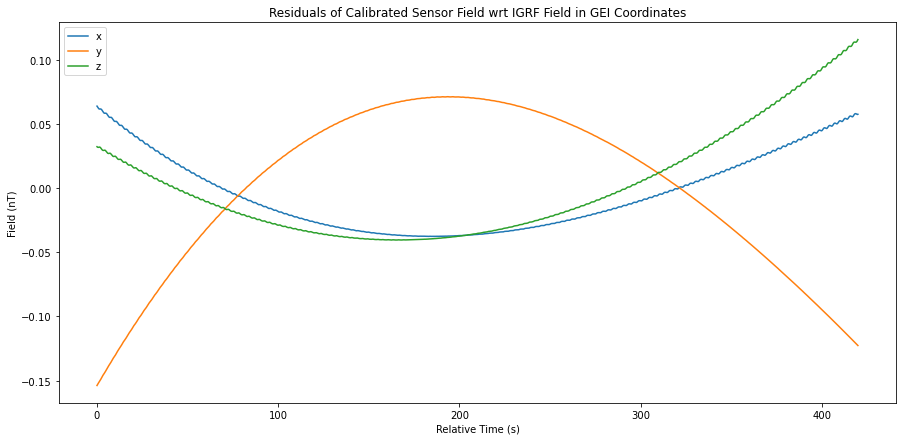

In [42]:
fig, ax = plt.subplots(1, figsize = (15, 7))

ax.plot(ctime, B_cal_GEI_x-B_IGRF_GEI_x, label='x')
ax.plot(ctime, B_cal_GEI_y-B_IGRF_GEI_y, label='y')
ax.plot(ctime, B_cal_GEI_z-B_IGRF_GEI_z, label='z')

ax.set_title('Residuals of Calibrated Sensor Field wrt IGRF Field in GEI Coordinates')
ax.set_xlabel('Relative Time (s)')
ax.set_ylabel('Field (nT)')
#ax.set_xlim(0, 10)
ax.legend()

In [43]:
B_cal_DMXL_x = np.zeros(len(ctime))
B_cal_DMXL_y = np.zeros(len(ctime))
B_cal_DMXL_z = np.zeros(len(ctime))

for i in range(len(ctime)):
    
    GEI_2_DMXL = np.linalg.inv(DMXL_2_GEI[i])
    
    B_cal_DMXL_x[i] = GEI_2_DMXL[0,0]*B_cal_GEI_x[i] + GEI_2_DMXL[0,1]*B_cal_GEI_y[i] + GEI_2_DMXL[0,2]*B_cal_GEI_z[i]
    B_cal_DMXL_y[i] = GEI_2_DMXL[1,0]*B_cal_GEI_x[i] + GEI_2_DMXL[1,1]*B_cal_GEI_y[i] + GEI_2_DMXL[1,2]*B_cal_GEI_z[i]
    B_cal_DMXL_z[i] = GEI_2_DMXL[2,0]*B_cal_GEI_x[i] + GEI_2_DMXL[2,1]*B_cal_GEI_y[i] + GEI_2_DMXL[2,2]*B_cal_GEI_z[i]    

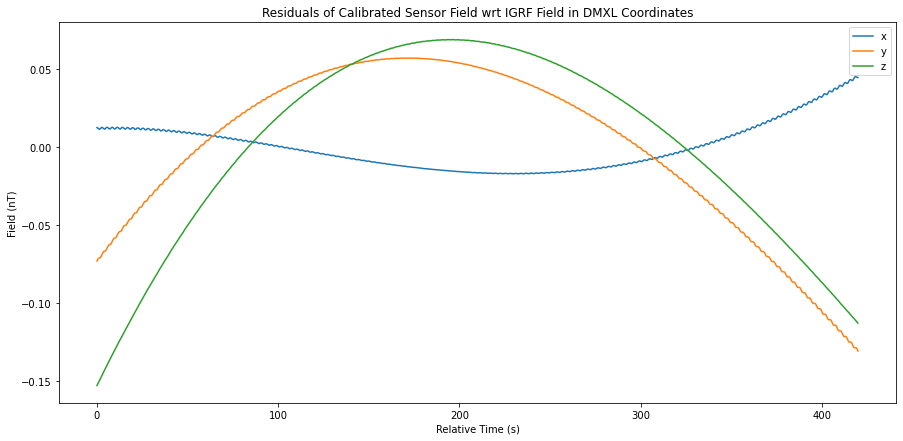

In [44]:
fig, ax = plt.subplots(1, figsize = (15, 7))

ax.plot(ctime, B_cal_DMXL_x-B_IGRF_DMXL_x, label='x')
ax.plot(ctime, B_cal_DMXL_y-B_IGRF_DMXL_y, label='y')
ax.plot(ctime, B_cal_DMXL_z-B_IGRF_DMXL_z, label='z')

ax.set_title('Residuals of Calibrated Sensor Field wrt IGRF Field in DMXL Coordinates')
ax.set_xlabel('Relative Time (s)')
ax.set_ylabel('Field (nT)')
#ax.set_xlim(0, 10)
ax.legend()

If you ran this notebook for simulated data, you can see that the residuals are extremely small, which is a great sign, and all the variables being optimized converge to their true values!

But if you ran this notebook for actual ELFIN data, while all optimization variables do converge to some values, you can see that the scale of the field residuals in DMXL coordinates is on the order of $10^3$ nT, which is about 10x larger than the expected magnitude for FACs. So something is not quite right, and the optimization algorithm appears to be stuck in some local minimum.